In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib
import datetime

In [2]:
def create_dataset(n_samples=10000):
    np.random.seed(42)
    
    # List of all Indian states
    indian_states = [
        'Andhra Pradesh', 'Arunachal Pradesh', 'Assam', 'Bihar', 'Chhattisgarh',
        'Goa', 'Gujarat', 'Haryana', 'Himachal Pradesh', 'Jharkhand', 'Karnataka',
        'Kerala', 'Madhya Pradesh', 'Maharashtra', 'Manipur', 'Meghalaya', 'Mizoram',
        'Nagaland', 'Odisha', 'Punjab', 'Rajasthan', 'Sikkim', 'Tamil Nadu',
        'Telangana', 'Tripura', 'Uttar Pradesh', 'Uttarakhand', 'West Bengal', 'Delhi'
    ]
    
    # More realistic merchant categories
    merchant_categories = [
        'Shopping', 'Food', 'Travel', 'Entertainment', 'Bills', 'Groceries',
        'Healthcare', 'Education', 'Electronics', 'Fashion', 'Others'
    ]
    
    # Generate data
    data = {
        'transaction_id': [f'TXN{str(i).zfill(8)}' for i in range(1, n_samples + 1)],
        # Modified user_id generation
        'user_id': [f'USER{str(np.random.randint(1000, 9999)).zfill(4)}' for _ in range(n_samples)],
        'transaction_date': [
            (datetime.datetime.now() - datetime.timedelta(
                days=np.random.randint(0, 365),
                hours=np.random.randint(0, 24),
                minutes=np.random.randint(0, 60)
            )).strftime('%Y-%m-%d %H:%M:%S') 
            for _ in range(n_samples)
        ],
        'amount': np.round(np.random.uniform(100, 100000, n_samples), 2),
        'merchant_category': np.random.choice(merchant_categories, n_samples),
        'location': np.random.choice(indian_states, n_samples),
        'time_of_day': np.random.randint(0, 24, n_samples),
        'multiple_transactions': np.random.randint(0, 5, n_samples),
        'high_risk_merchant': np.random.choice([0, 1], n_samples, p=[0.9, 0.1]),
        'unusual_location': np.random.choice([0, 1], n_samples, p=[0.95, 0.05]),
        'device_type': np.random.choice(['Mobile', 'Desktop', 'Tablet'], n_samples, p=[0.7, 0.2, 0.1]),
        'payment_method': np.random.choice(['UPI', 'Wallet', 'Card'], n_samples, p=[0.6, 0.3, 0.1])
    }
    
    # Generate fraud labels with sophisticated rules
    fraud_probability = (
        0.15 * data['multiple_transactions'] +  # Multiple transactions increase risk
        0.25 * data['high_risk_merchant'] +    # High risk merchant is a strong indicator
        0.20 * data['unusual_location'] +      # Unusual location adds to risk
        0.15 * (np.array(data['amount']) > 50000).astype(int) +  # High amounts are riskier
        0.15 * (np.array(data['time_of_day'] >= 22) | (np.array(data['time_of_day'] <= 4))).astype(int) +  # Late night/early morning
        0.10 * (np.array([cat in ['Electronics', 'Fashion'] for cat in data['merchant_category']])).astype(int)  # Risky categories
    )
    
    # Add some randomness to fraud determination
    data['is_fraud'] = (fraud_probability + np.random.normal(0, 0.1, n_samples) > 1.0).astype(int)
    
    return pd.DataFrame(data)

In [4]:
# Create dataset
df = create_dataset()

# Save as CSV
csv_path = 'data/fraud_data.csv'
df.to_csv(csv_path, index=False)

# Display information about the dataset
print("Dataset shape:", df.shape)
print("\nColumns:", list(df.columns))
print("\nSample data:")
display(df.head())

print("\nFraud Distribution:")
print(df['is_fraud'].value_counts(normalize=True))

print("\nFiles saved:")
print(f"1. CSV file: {csv_path}")

# Display summary statistics
print("\nSummary Statistics:")
display(df.describe())

# Display value counts for categorical columns
categorical_columns = ['merchant_category', 'location', 'device_type', 'payment_method']
for col in categorical_columns:
    print(f"\nDistribution of {col}:")
    print(df[col].value_counts())

Dataset shape: (10000, 13)

Columns: ['transaction_id', 'user_id', 'transaction_date', 'amount', 'merchant_category', 'location', 'time_of_day', 'multiple_transactions', 'high_risk_merchant', 'unusual_location', 'device_type', 'payment_method', 'is_fraud']

Sample data:


,transaction_id,user_id,transaction_date,amount,merchant_category,location,time_of_day,multiple_transactions,high_risk_merchant,unusual_location,device_type,payment_method,is_fraud
0,TXN00000001,USER8270,2023-12-30 01:22:45,37805.44,Electronics,Uttarakhand,0,3,0,0,Mobile,UPI,0
1,TXN00000002,USER1860,2024-10-20 12:28:45,71805.54,Entertainment,Haryana,17,1,0,0,Mobile,Card,0
2,TXN00000003,USER6390,2024-04-25 07:59:45,14468.14,Travel,Madhya Pradesh,14,3,0,0,Mobile,UPI,0
3,TXN00000004,USER6191,2024-04-04 18:41:45,91378.41,Healthcare,Sikkim,10,0,0,0,Mobile,UPI,0
4,TXN00000005,USER6734,2024-09-08 01:01:45,87957.79,Bills,Manipur,17,3,0,0,Desktop,UPI,0



Fraud Distribution:
is_fraud
0    0.9735
1    0.0265
Name: proportion, dtype: float64

Files saved:
1. CSV file: data/fraud_data.csv

Summary Statistics:


,amount,time_of_day,multiple_transactions,high_risk_merchant,unusual_location,is_fraud
count,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,49770.668529,11.510400,2.00220,0.103000,0.051500,0.026500
std,28795.344515,6.903597,1.41499,0.303974,0.221026,0.160625
min,110.230000,0.000000,0.00000,0.000000,0.000000,0.000000
25%,25196.237500,5.000000,1.00000,0.000000,0.000000,0.000000
50%,49704.755000,12.000000,2.00000,0.000000,0.000000,0.000000
75%,74691.802500,17.000000,3.00000,0.000000,0.000000,0.000000
max,99997.390000,23.000000,4.00000,1.000000,1.000000,1.000000



Distribution of merchant_category:
merchant_category
Groceries        949
Electronics      938
Healthcare       930
Travel           922
Bills            921
Education        918
Fashion          901
Shopping         895
Entertainment    880
Food             878
Others           868
Name: count, dtype: int64

Distribution of location:
location
Tripura              368
Nagaland             364
Bihar                362
Rajasthan            362
Maharashtra          361
Uttarakhand          359
Madhya Pradesh       357
West Bengal          356
Kerala               354
Mizoram              353
Assam                353
Odisha               352
Goa                  351
Telangana            351
Himachal Pradesh     348
Karnataka            347
Sikkim               346
Arunachal Pradesh    344
Tamil Nadu           342
Chhattisgarh         340
Meghalaya            335
Jharkhand            332
Gujarat              332
Punjab               329
Delhi                326
Uttar Pradesh        326
Har

In [5]:
# Prepare features
def prepare_features(df):
    df_processed = df.copy()
    
    # Convert categorical variables
    df_processed = pd.get_dummies(df_processed, columns=['merchant_category', 'location'])
    
    # Extract time features
    df_processed['hour'] = pd.to_datetime(df_processed['transaction_date']).dt.hour
    df_processed['day_of_week'] = pd.to_datetime(df_processed['transaction_date']).dt.dayofweek
    
    # Drop unnecessary columns
    columns_to_drop = ['transaction_id', 'user_id', 'transaction_date', 'time_of_day']
    df_processed = df_processed.drop(columns_to_drop, axis=1)
    
    return df_processed

In [6]:
# Prepare features
def prepare_features(df):
    df_processed = df.copy()
    
    # Convert categorical variables
    categorical_columns = ['merchant_category', 'location', 'device_type', 'payment_method']
    df_processed = pd.get_dummies(df_processed, columns=categorical_columns)
    
    # Extract time features from transaction_date
    df_processed['hour'] = pd.to_datetime(df_processed['transaction_date']).dt.hour
    df_processed['day_of_week'] = pd.to_datetime(df_processed['transaction_date']).dt.dayofweek
    
    # Drop unnecessary columns
    columns_to_drop = ['transaction_id', 'user_id', 'transaction_date', 'time_of_day']
    df_processed = df_processed.drop(columns_to_drop, axis=1)
    
    # Ensure all columns are numeric
    numeric_columns = ['amount', 'multiple_transactions', 'high_risk_merchant', 
                      'unusual_location', 'hour', 'day_of_week']
    
    for col in numeric_columns:
        df_processed[col] = pd.to_numeric(df_processed[col])
    
    return df_processed

In [7]:
# Prepare data for training
df_processed = prepare_features(df)

# Verify all columns are numeric
print("Column datatypes:")
print(df_processed.dtypes)

# Split features and target
X = df_processed.drop('is_fraud', axis=1)
y = df_processed['is_fraud']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nTraining set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

# Display feature names
print("\nFeature names:")
print(list(X.columns))

Column datatypes:
amount                             float64
multiple_transactions                int32
high_risk_merchant                   int32
unusual_location                     int32
is_fraud                             int32
merchant_category_Bills               bool
merchant_category_Education           bool
merchant_category_Electronics         bool
merchant_category_Entertainment       bool
merchant_category_Fashion             bool
merchant_category_Food                bool
merchant_category_Groceries           bool
merchant_category_Healthcare          bool
merchant_category_Others              bool
merchant_category_Shopping            bool
merchant_category_Travel              bool
location_Andhra Pradesh               bool
location_Arunachal Pradesh            bool
location_Assam                        bool
location_Bihar                        bool
location_Chhattisgarh                 bool
location_Delhi                        bool
location_Goa                        

Training the model...

Making predictions...

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1956
           1       0.34      0.50      0.40        44

    accuracy                           0.97      2000
   macro avg       0.66      0.74      0.69      2000
weighted avg       0.97      0.97      0.97      2000


Confusion Matrix:
[[1913   43]
 [  22   22]]

Top 15 Most Important Features:


,feature,importance
1,multiple_transactions,0.346779
2,high_risk_merchant,0.194091
0,amount,0.133910
3,unusual_location,0.069975
50,hour,0.040535
51,day_of_week,0.028701
6,merchant_category_Electronics,0.015547
8,merchant_category_Fashion,0.014961
49,payment_method_Wallet,0.007010
48,payment_method_UPI,0.006917


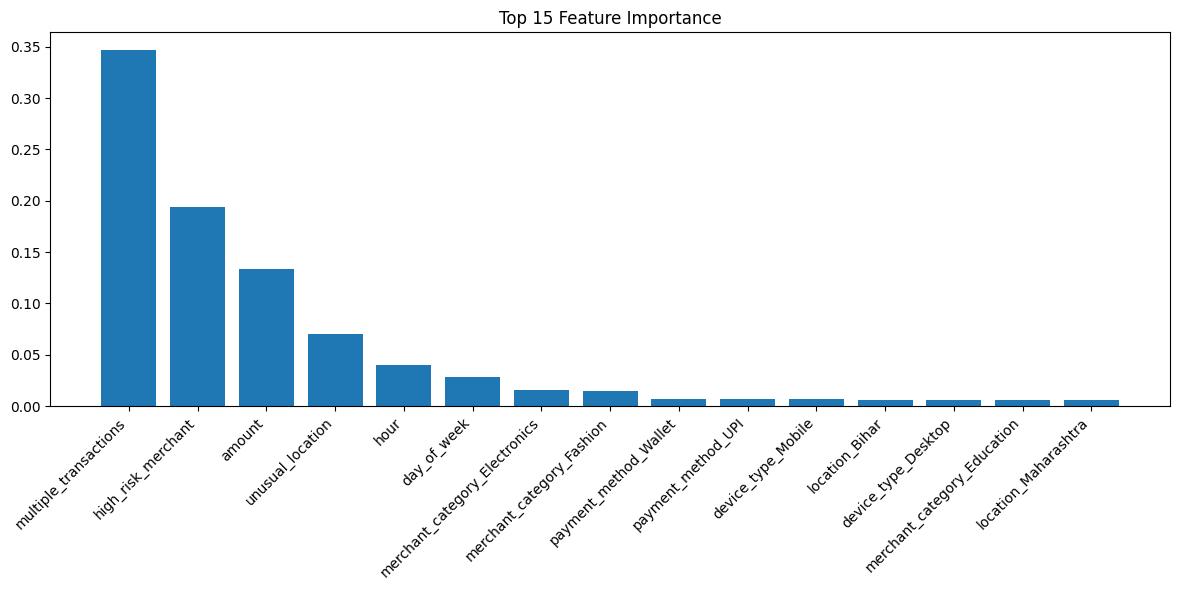

In [8]:
# Train model with improved parameters
model = RandomForestClassifier(
    n_estimators=200,          # Number of trees
    max_depth=15,              # Maximum depth of trees
    min_samples_split=5,       # Minimum samples required to split
    min_samples_leaf=2,        # Minimum samples required at leaf node
    random_state=42,
    class_weight='balanced',   # Handle class imbalance
    n_jobs=-1                  # Use all available cores
)

# Fit the model
print("Training the model...")
model.fit(X_train_scaled, y_train)

# Make predictions
print("\nMaking predictions...")
y_pred = model.predict(X_test_scaled)
y_pred_prob = model.predict_proba(X_test_scaled)[:, 1]

# Print evaluation metrics
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

# Feature importance analysis
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False)

print("\nTop 15 Most Important Features:")
display(feature_importance.head(15))

# Plot feature importance
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.bar(feature_importance['feature'][:15], feature_importance['importance'][:15])
plt.xticks(rotation=45, ha='right')
plt.title('Top 15 Feature Importance')
plt.tight_layout()
plt.show()

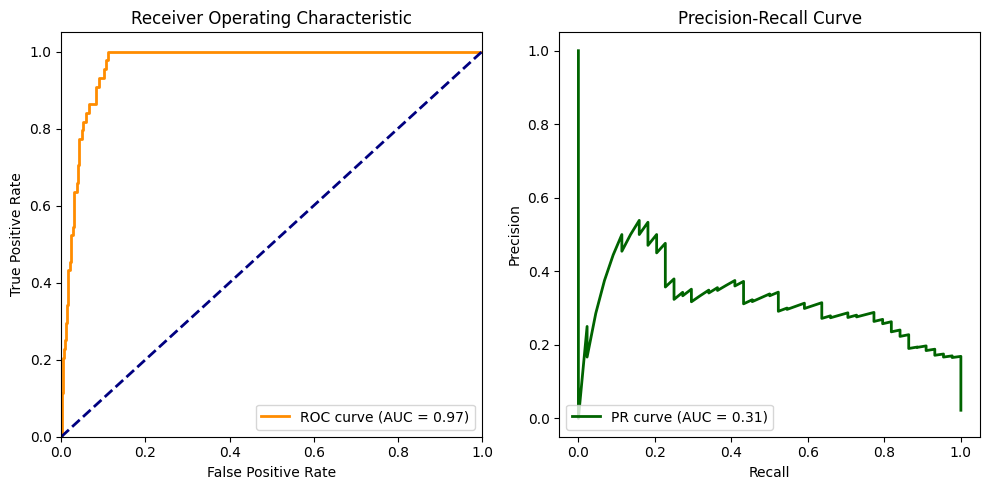


Detailed Performance Metrics:
ROC AUC Score: 0.9673
PR AUC Score: 0.3125
F1 Score: 0.4037
Average Precision Score: 0.3247


In [9]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve
import matplotlib.pyplot as plt

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_pred_prob)
pr_auc = auc(recall, precision)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='darkgreen', lw=2, label=f'PR curve (AUC = {pr_auc:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()

# Print additional metrics
from sklearn.metrics import average_precision_score, f1_score

print("\nDetailed Performance Metrics:")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"PR AUC Score: {pr_auc:.4f}")
print(f"F1 Score: {f1_score(y_test, y_pred):.4f}")
print(f"Average Precision Score: {average_precision_score(y_test, y_pred_prob):.4f}")

In [10]:
# Create models directory if it doesn't exist
import os
if not os.path.exists('../models'):
    os.makedirs('../models')

# Save model and related components
print("Saving model and components...")

# Save the model
model_path = '../models/fraud_model.pkl'
joblib.dump(model, model_path)
print(f"Model saved to: {model_path}")

# Save the scaler
scaler_path = '../models/scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to: {scaler_path}")

# Save feature names
feature_names_path = '../models/feature_names.pkl'
joblib.dump(list(X.columns), feature_names_path)
print(f"Feature names saved to: {feature_names_path}")

# Save model metadata
model_metadata = {
    'n_features': X.shape[1],
    'feature_names': list(X.columns),
    'training_date': datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
    'model_parameters': model.get_params(),
    'performance_metrics': {
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'f1_score': f1_score(y_test, y_pred),
        'average_precision': average_precision_score(y_test, y_pred_prob)
    }
}

metadata_path = '../models/model_metadata.pkl'
joblib.dump(model_metadata, metadata_path)
print(f"Model metadata saved to: {metadata_path}")

print("\nAll components saved successfully!")

# Display final model summary
print("\nModel Summary:")
print(f"Number of features: {X.shape[1]}")
print(f"Training samples: {X_train.shape[0]}")
print(f"Testing samples: {X_test.shape[0]}")
print(f"Feature names: {', '.join(X.columns[:10])}...")

Saving model and components...
Model saved to: ../models/fraud_model.pkl
Scaler saved to: ../models/scaler.pkl
Feature names saved to: ../models/feature_names.pkl
Model metadata saved to: ../models/model_metadata.pkl

All components saved successfully!

Model Summary:
Number of features: 52
Training samples: 8000
Testing samples: 2000
Feature names: amount, multiple_transactions, high_risk_merchant, unusual_location, merchant_category_Bills, merchant_category_Education, merchant_category_Electronics, merchant_category_Entertainment, merchant_category_Fashion, merchant_category_Food...


In [11]:
# Create models directory if it doesn't exist
import os
if not os.path.exists('../models'):
    os.makedirs('../models')

# Save model and related components
print("Saving model and components...")

# Save the model
model_path = 'models/fraud_model.pkl'
joblib.dump(model, model_path)
print(f"Model saved to: {model_path}")

# Save the scaler
scaler_path = 'models/scaler.pkl'
joblib.dump(scaler, scaler_path)
print(f"Scaler saved to: {scaler_path}")

# Save feature names
feature_names_path = 'models/feature_names.pkl'
joblib.dump(list(X.columns), feature_names_path)
print(f"Feature names saved to: {feature_names_path}")

Saving model and components...
Model saved to: models/fraud_model.pkl
Scaler saved to: models/scaler.pkl
Feature names saved to: models/feature_names.pkl
